# Baseline
Using pre-trained ResNet50

## Initial Setup

Auto update from code base

In [1]:
%load_ext autoreload
%autoreload 2

Import libraries

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import cv2, os, pickle
from IPython.display import display
from PIL import Image
from tensorflow import set_random_seed
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.applications.resnet50 import ResNet50

from src.model_api import getPretrainedModelV2
from src.generator import DataGenerator
from src.preprocessing import image_load_resize
from src.prediction import array_filter, array_to_string

Using TensorFlow backend.


## Exploring the data

In [3]:
df = pd.read_csv('data/raw/train.csv')
df.head()

,Image,Id
0,0000e88ab.jpg,w_f48451c
1,0001f9222.jpg,w_c3d896a
2,00029d126.jpg,w_20df2c5
3,00050a15a.jpg,new_whale
4,0005c1ef8.jpg,new_whale


In [4]:
df.Id.value_counts().head()

new_whale    9664
w_23a388d      73
w_9b5109b      65
w_9c506f6      62
w_0369a5c      61
Name: Id, dtype: int64

In [5]:
print('Percentage of whales tagged as new_whale: {:.2f}%'.format((df.Id == 'new_whale').mean() * 100))

Percentage of whales tagged as new_whale: 38.11%


In [6]:
print('Percentages of whales with only one image associated with them: {:.2f}%'
      .format((df.Id.value_counts() == 1).mean() * 100))

Percentages of whales with only one image associated with them: 41.42%


In [7]:
print('Number of unique labels:', df.Id.nunique())

Number of unique labels: 5005


In [5]:
df.shape

(25361, 2)

In [5]:
classes_list = list(set(df.Id))
len(classes_list)

5005

## Train Baseline Model

Create ImageDataGenerator instance for data augmentation

In [6]:
BATCH_SIZE = 64
TARGET_SIZE = (224, 224)
SEED = 2019
NUM_CLASSES = len(classes_list)

train_generator = ImageDataGenerator(rescale=1/255.,
                                     rotation_range=20,
                                     width_shift_range=0.1,
                                     height_shift_range=0.1,
                                     shear_range=0.5,
                                     zoom_range=(0.9, 1.1),
                                     horizontal_flip=True,
                                     vertical_flip=False,
                                     fill_mode='constant',
                                     cval=0,
                                     validation_split=0.1)

train_image_generator = train_generator.flow_from_dataframe(dataframe=df, directory='data/derived/preprocessed_train', 
                                                            x_col='Image', y_col='Id', has_ext=True,
                                                            classes=classes_list, 
                                                            target_size=TARGET_SIZE, interpolation='nearest',
                                                            batch_size=BATCH_SIZE, seed=SEED, subset='training')
val_image_generator = train_generator.flow_from_dataframe(dataframe=df, directory='data/derived/preprocessed_train', 
                                                          x_col='Image', y_col='Id', has_ext=True,
                                                          classes=classes_list,
                                                          target_size=TARGET_SIZE, interpolation='nearest',
                                                          batch_size=BATCH_SIZE, seed=SEED, subset='validation')

INPUT_SHAPE = (224, 224, 3)
STEPS_PER_EPOCH = train_image_generator.n // BATCH_SIZE
VALIDATION_STEPS = val_image_generator.n // BATCH_SIZE

Found 22825 images belonging to 5005 classes.
Found 2536 images belonging to 5005 classes.


Build model

In [10]:
model = getPretrainedModelV2(ResNet50(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE,
                                      pooling='max'),
                             num_classes=NUM_CLASSES, num_layers_unfreeze=0, optimizer='adam',
                             fc_size=100, dropout_rate=0.3)

Train model for 2 epochs

In [11]:
set_random_seed(SEED)
np.random.seed(SEED)
model.fit_generator(train_image_generator, steps_per_epoch=90, epochs=2,
                    validation_data=val_image_generator, validation_steps=10, workers=12)

Epoch 1/2
90/90 [==============================] - 97s 1s/step - loss: 6.4355 - acc: 0.3748 - val_loss: 7.7358 - val_acc: 0.3906
Epoch 2/2
90/90 [==============================] - 67s 744ms/step - loss: 6.3215 - acc: 0.3830 - val_loss: 7.8271 - val_acc: 0.3922


Train with different combinations of Adam optimizers to determine learning rate

In [13]:
learning_rate_list = [1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1]
train_loss_list = []
val_loss_list = []
for learning_rate in learning_rate_list:
    model = getPretrainedModelV2(ResNet50(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE,
                                      pooling='max'),
                             num_classes=NUM_CLASSES, num_layers_unfreeze=0, optimizer=Adam(learning_rate))
    set_random_seed(SEED)
    np.random.seed(SEED)
    hist = model.fit_generator(train_image_generator, steps_per_epoch=90, epochs=2,
                               validation_data=val_image_generator, validation_steps=10, workers=12, verbose=0)
    train_loss_list.append(hist.history['loss'][-1])
    val_loss_list.append(hist.history['val_loss'][-1])

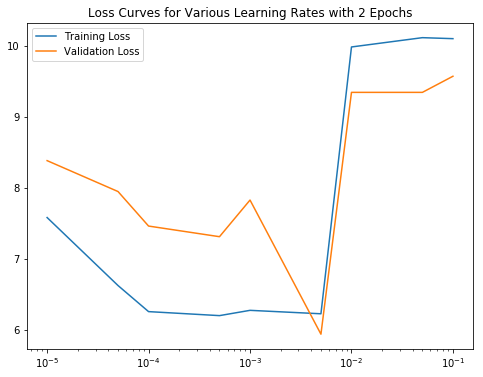

In [14]:
plt.figure(figsize=(8, 6))
plt.plot(learning_rate_list, train_loss_list, label='Training Loss')
plt.plot(learning_rate_list, val_loss_list, label='Validation Loss')
plt.xscale('log')
plt.legend(loc='best')
plt.title('Loss Curves for Various Learning Rates with 2 Epochs')
plt.savefig('loss_curves_learning_rate.png')

Train model for submission

In [5]:
NUM_CLASSES = len(classes_list)
TARGET_SIZE = (224, 224)
INPUT_SHAPE = (224, 224, 3)
BATCH_SIZE = 64
SEED = 2019
STEPS_PER_EPOCH = len(df) // BATCH_SIZE
BEST_LR = 5e-3

train_generator = ImageDataGenerator(rescale=1/255.,
                                     fill_mode='constant',
                                     cval=0,
                                     validation_split=0.1)

train_image_generator = train_generator.flow_from_dataframe(dataframe=df, directory='data/derived/preprocessed_train', 
                                                            x_col='Image', y_col='Id', has_ext=True, classes=classes_list,
                                                            target_size=TARGET_SIZE, interpolation='nearest',
                                                            batch_size=BATCH_SIZE, seed=SEED)

filepath = 'models/weights-baseline-{epoch:03d}.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='loss', save_best_only=False, save_weights_only=True,
                             mode='min')
reduceLR = ReduceLROnPlateau(monitor='loss', patience=3, min_delta=0.1, factor=0.25, min_lr=1e-5, verbose=1)

model = getPretrainedModelV2(ResNet50(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE, pooling='max'),
                             num_classes=NUM_CLASSES, num_layers_unfreeze=0, optimizer=Adam(BEST_LR, decay=0.01))

Found 25361 images belonging to 5005 classes.


In [6]:
set_random_seed(SEED)
np.random.seed(SEED)
NUM_EPOCHS = 30
hist = model.fit_generator(train_image_generator, steps_per_epoch=STEPS_PER_EPOCH, epochs=NUM_EPOCHS,
                           workers=12, verbose=0, callbacks=[checkpoint, reduceLR])


Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 00013: ReduceLROnPlateau reducing learning rate to 7.812499825377017e-05.

Epoch 00016: ReduceLROnPlateau reducing learning rate to 1.9531249563442543e-05.

Epoch 00019: ReduceLROnPlateau reducing learning rate to 1e-05.


In [7]:
len(hist.history['loss'])

30

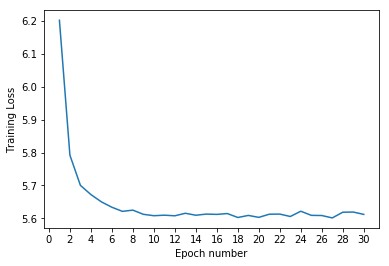

In [8]:
plt.plot(list(range(1, NUM_EPOCHS + 1)), hist.history['loss'])
plt.xlabel('Epoch number')
plt.ylabel('Training Loss')
plt.xticks(range(0, NUM_EPOCHS + 1, 2));

Model prediction

In [9]:
with open('data/derived/test_file_names.pickle', 'rb') as file:
    filenames_test = pickle.load(file)
df_test = pd.DataFrame({'Image': filenames_test})
test_generator = DataGenerator(dataframe=df_test, x_col='Image', y_col=None, batch_size=BATCH_SIZE,
                               target_size=TARGET_SIZE, directory='data/derived/preprocessed_test',
                               preprocess_for='resnet50')

model.load_weights('models/weights-baseline-008.hdf5')

# Save final weights if it doesn't exist
weights_path = 'models/weights-baseline-final.hdf5'
if os.path.exists(weights_path):
    print('Path {} exists'.format(weights_path))
else:
    model.save_weights(weights_path)

preds = model.predict_generator(test_generator)
preds.shape

Total no of observations in sequence: 7960


/home/yxlee245/anaconda3/envs/whale_env/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/yxlee245/anaconda3/envs/whale_env/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


(7960, 5005)

Obtain labels with top 5 softmax values for each array row and concatenate labels

In [10]:
labels = np.array(classes_list)
top5_indices = np.apply_along_axis(array_filter, arr=preds, axis=1, n_top=5,
                                   labels=labels)
predictions_array = np.apply_along_axis(array_to_string, arr=top5_indices, axis=1)

Create submission DataFrame and export as CSV file

In [11]:
submission_df = pd.DataFrame({'Image': df_test.Image, 'Id': predictions_array})
submission_df.to_csv('data/submissions/submission_001.csv', index=False)
print(submission_df.head(10))

           Image                                                 Id
0  660352b03.jpg  new_whale w_9b5109b w_23a388d w_700ebb4 w_3de579a
1  bec66f23c.jpg  new_whale w_9b5109b w_700ebb4 w_23a388d w_3de579a
2  fb8c2c146.jpg  new_whale w_9b5109b w_23a388d w_700ebb4 w_3de579a
3  0ff9cd790.jpg  new_whale w_9b5109b w_23a388d w_700ebb4 w_3de579a
4  861e6c332.jpg  new_whale w_9b5109b w_700ebb4 w_23a388d w_3de579a
5  736a568a4.jpg  new_whale w_9b5109b w_700ebb4 w_23a388d w_3de579a
6  4188acc6e.jpg  new_whale w_9b5109b w_23a388d w_700ebb4 w_3de579a
7  101351ac6.jpg  new_whale w_9b5109b w_23a388d w_700ebb4 w_3de579a
8  de4828574.jpg  new_whale w_9b5109b w_23a388d w_700ebb4 w_3de579a
9  2c4d75bc2.jpg  new_whale w_9b5109b w_700ebb4 w_23a388d w_3de579a


Kaggle score: 0.277